<a href="https://www.kaggle.com/code/aisuko/schedulers-performance?scriptVersionId=164528561" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Diffusion pipeline of diffusers are inherently a collection of diffusion models and schedulers that are partly independent from each other. This means that one is able to switch out parts of the pipeline to better customize a pipeline to one's use case. The best example of this is the Schedulers.

Whereas diffusion models usually simply define the forward pass from noise to a less noisy sample, schedulers define the whole denoising process, i.e.:
* How many denosing steps?
* Stochastic or deterministic?
* What algorithm to use to find the denoised sample

They can be quite complex and often define a trade-off between **denoising speed** and **denoising quality**. It is extremly difficult to measure quantiatively which shceduler works best for a given diffusion pipeline, so it is often recommended to simply try out which works best.

In [1]:
%%capture
!pip install diffusers==0.26.3
# ImportError: cannot import name 'CpuOffload' from 'accelerate.hooks'
!pip install transformers==4.38.1
!pip install accelerate==0.27.2

In [2]:
import os
import torch
import warnings

os.environ['MODEL_NAME']='runwayml/stable-diffusion-v1-5'

if torch.cuda.is_available():
    torch_device = 'cuda'
else:
    torch_device = 'cpu'

warnings.filterwarnings('ignore')

print(torch_device)

cuda


# Loading the Model

In [3]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(os.getenv('MODEL_NAME'), torch_dtype=torch.float16)
pipeline.to(torch_device)
print(pipeline.config)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

FrozenDict([('vae', ('diffusers', 'AutoencoderKL')), ('text_encoder', ('transformers', 'CLIPTextModel')), ('tokenizer', ('transformers', 'CLIPTokenizer')), ('unet', ('diffusers', 'UNet2DConditionModel')), ('scheduler', ('diffusers', 'PNDMScheduler')), ('safety_checker', ('stable_diffusion', 'StableDiffusionSafetyChecker')), ('feature_extractor', ('transformers', 'CLIPImageProcessor')), ('image_encoder', (None, None)), ('requires_safety_checker', True), ('_name_or_path', 'runwayml/stable-diffusion-v1-5')])


# Access the Scheduler

The scheduler is always one of the components of the pipeline and is usually called "scheduler". So it can be accessed cia the "scheduler" property.

We can see that the scheduler is of type PNDMScheduler. Cool, now let's compare the scheduler in its performance to other schedulers. First we define a prompt on which we will test all the different schedulers:

In [4]:
pipeline.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.26.3",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

Next, we create a generator from a random seed that will ensure that we can generate smimilar images as well as run the pipeline:

  0%|          | 0/50 [00:00<?, ?it/s]

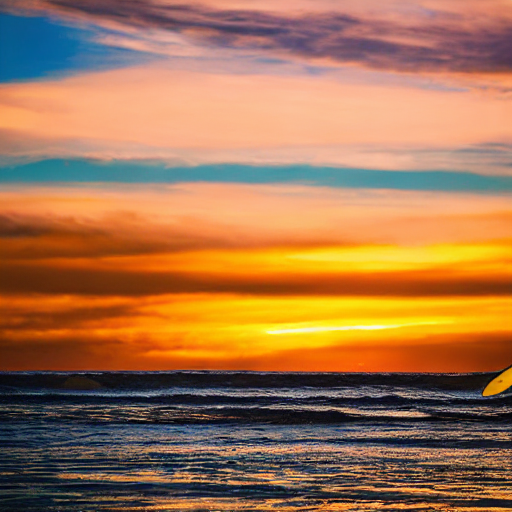

In [5]:
prompt = 'A dreamlike scene of a lone surfer riding a wave at sunset, silhouetted against the vibrant colors of the Melbourne sky.'

generator = torch.Generator(device=torch_device).manual_seed(8)
image = pipeline(prompt, generator=generator).images[0]
image

# Changing the scheduler

Now we show how easy it is to change the scheduler or a pipeline. Every scheduler has a property SchedulerMixin. compatibles which defines all compatible schedulers. You can take a look at all available, compatible schedulers for the Stable Diffusion pipeline as follows:

In [6]:
pipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSD

# Comparing the input prompt with all other schedulers

To change the scheduler of the pipeline you can make use of the convenient ConfigMixin.config property in combination with the ConfigMixin.from_config() function, return a dictionary of the configuration of the scheduler. This configuration can then be used to instantiate a shcuduler of a different class that is compatible with the pipeline. Here, we change the scheduler to the DDIMScheduler.

In [7]:
from diffusers import DDIMScheduler

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('clip_sample', False),
            ('set_alpha_to_one', False),
            ('steps_offset', 1),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['sample_max_value',
              'timestep_spacing',
              'prediction_type',
              'clip_sample_range',
              'dynamic_thresholding_ratio',
              'rescale_betas_zero_snr',
              'thresholding']),
            ('skip_prk_steps', True),
            ('_class_name', 'PNDMScheduler'),
            ('_di

  0%|          | 0/50 [00:00<?, ?it/s]

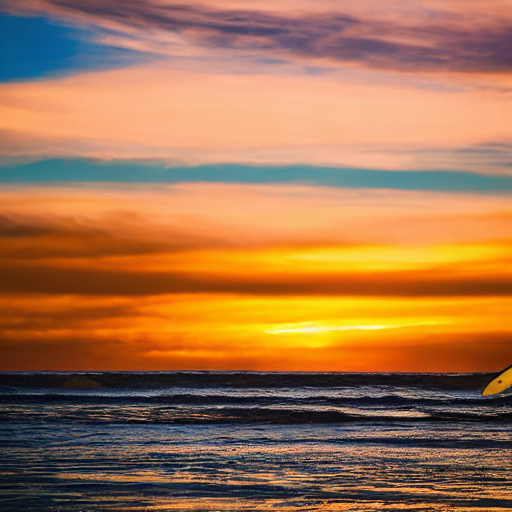

In [8]:
generator = torch.Generator(device=torch_device).manual_seed(8)
image = pipeline(prompt, generator=generator).images[0]
image

# Compare schedulers

So far we have tried running the stable diffusion pipeline with two schedulers:
* PNDMScheduler
* DDIMScheduler

## LMSDiscreteScheduler usually leads to **better results**

  0%|          | 0/50 [00:00<?, ?it/s]

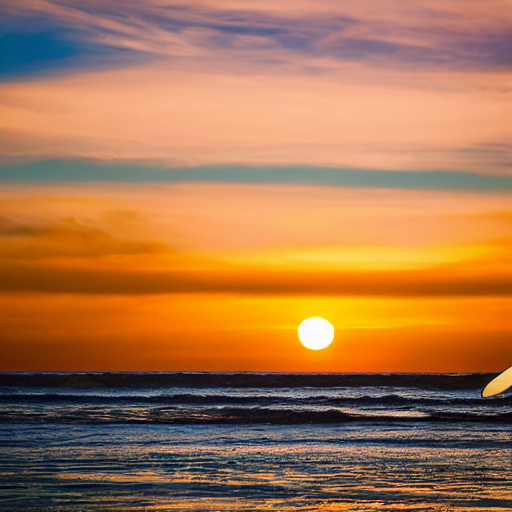

In [9]:
from diffusers import LMSDiscreteScheduler

pipeline.scheduler = LMSDiscreteScheduler.from_config(pipeline.scheduler.config)

generator = torch.Generator(device=torch_device).manual_seed(8)
image= pipeline(prompt, generator=generator).images[0]
image

## EulerDiscreteScheduler and EulerAncestralDiscreteScheduler can generate **high quality** results with as little as 30 steps

  0%|          | 0/30 [00:00<?, ?it/s]

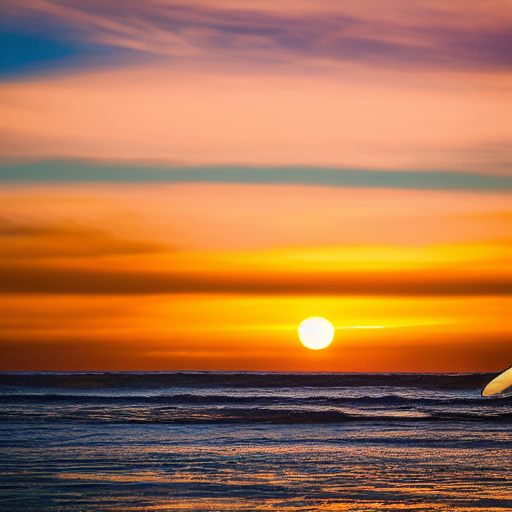

In [10]:
from diffusers import EulerDiscreteScheduler

pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)

generator = torch.Generator(device=torch_device).manual_seed(8)
image = pipeline(prompt, generator=generator, num_inference_steps=30).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

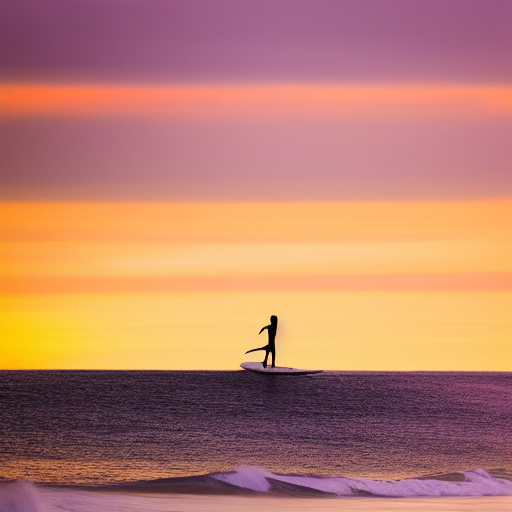

In [11]:
from diffusers import EulerAncestralDiscreteScheduler

pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config)

generator = torch.Generator(device=torch_device).manual_seed(8)
image = pipeline(prompt, generator=generator, num_inference_steps=30).images[0]
image

## DPMSolverMultistepScheduler give arguably the **best speed/quality trade-off** and can be run with as little as 20 steps.

  0%|          | 0/30 [00:00<?, ?it/s]

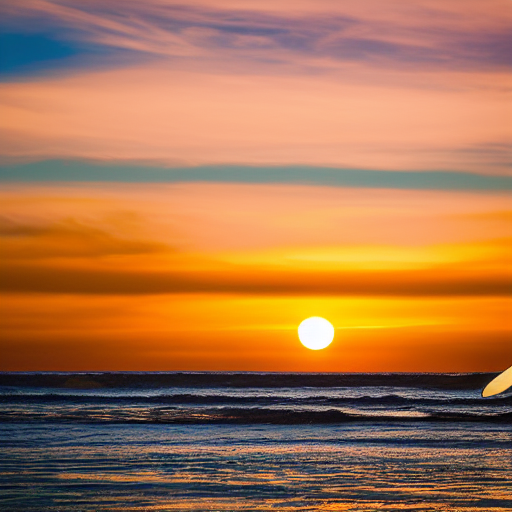

In [12]:
from diffusers import DPMSolverMultistepScheduler

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

generator = torch.Generator(device=torch_device).manual_seed(8)
image = pipeline(prompt, generator=generator, num_inference_steps=30).images[0]
image

# Summary

As you can see most images look very similar and are arguably of very similar quality. It often reallt dependes on the specific use case which scheduler to choose. A good approach is always to run multiple shcedulers to compare results.